In [14]:
import glob
import os
import json

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import cPickle as pkl


from pipeline.python.classifications import experiment_classes as util


import scipy.stats as spstats

from pipeline.python.utils import label_figure, natural_keys
from pipeline.python.classifications import bootstrap_fit_tuning_curves as osi
from pipeline.python.classifications import get_dataset_stats as gd

In [2]:
%matplotlib notebook

# Get dataset info

In [3]:
options = ['-t', 'traces001']

optsE = gd.extract_options(options)


rootdir = optsE.rootdir
aggregate_dir = optsE.aggregate_dir
fov_type = optsE.fov_type
traceid = optsE.traceid
state  = optsE.state
response_type = optsE.response_type
print response_type
print aggregate_dir

dff
/n/coxfs01/julianarhee/aggregate-visual-areas


In [4]:
sdata = gd.get_dataset_info(aggregate_dir=aggregate_dir, traceid=traceid,
                           fov_type=fov_type, state=state)

In [5]:
sdata.head()

animalid experiment            fov   session visual_area  fovnum
0    JC084        rfs  FOV1_zoom2p0x  20190522          V1       1
1    JC084   gratings  FOV1_zoom2p0x  20190522          V1       1
2    JC084      blobs  FOV1_zoom2p0x  20190522          V1       1
3    JC084     retino  FOV1_zoom2p0x  20190522          V1       1
4    JC084        rfs  FOV1_zoom2p0x  20190525          Lm       1

In [6]:
always_exclude = ['20190426_JC078']

#### Look at 1 session first

In [11]:
animalid = 'JC084'
session = '20190525'
fov = 'FOV1_zoom2p0x'

In [12]:
responsive_test = 'nstds'
responsive_thr = 10
n_stds = 2.5

stats_desc = util.get_stats_desc(traceid=traceid, responsive_test=responsive_test, 
                    responsive_thr=responsive_thr, n_stds=n_stds)

In [27]:
reload(util)

<module 'pipeline.python.classifications.experiment_classes' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py'>

In [28]:

S = util.Session(animalid, session, fov)

roi_list = S.get_all_responsive_cells(traceid=traceid, response_type=response_type,
                                  responsive_test=responsive_test, responsive_thr=responsive_thr, fit_thr=0.5)



[JC084] 20190525 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
... [JC084|20190525|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
['/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/combined_rfs_static']
['/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/combined_rfs_static']
... run: combined_rfs_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
... [JC084|20190525|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
['/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/combined_gratings_static']
['/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/combined_gratings_static']
... run: combined_gratings_static
... getting responsive cells (test: nstds, thr: 10.00')
-- stats: combined_gratings_static
['/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_e97cee_trac

In [29]:
len(roi_list)

169

#### Create dataframe: columns = cells, rows = average response across reps of each condition

In [13]:
labels = S.experiments[experiment].data.labels
labels.head()

trial_refix = dict((trial, i) for i, trial in enumerate(sorted(labels['trial'].unique(), key=natural_keys)))

cfgs = []
for config, g in labels.groupby(['config']):
    trial_ixs = np.array([trial_refix[trial] for trial in sorted(g['trial'].unique(), key=natural_keys)])
    curr_trials = tstats.loc[trial_ixs]
    assert len(np.where(np.isnan(curr_trials))[0]) == 0
    cfgs.append( pd.Series(data=curr_trials.mean(axis=0), name=config) )
    
configdf = pd.DataFrame(cfgs)
    

In [14]:
configdf.head()

0         2         5         6         7         9    \
config001  0.079228  0.135121  0.047725  0.062660  0.058300  0.040847   
config002  0.118341  0.184734  0.071284  0.091117  0.137780  0.060109   
config003 -0.013332  0.008223 -0.033071 -0.060936  0.027107  0.084186   
config004 -0.016769 -0.013923 -0.016282 -0.073855  0.014335  0.074551   
config005  0.093920  0.171499  0.018054  0.097042  0.119640  0.050814   

                11        17        18        21     ...          414  \
config001  0.043208  0.050923  0.018850  0.029469    ...     0.065740   
config002  0.108049  0.090345  0.021019  0.050737    ...     0.093750   
config003 -0.007926  0.011979 -0.066652  0.007006    ...     0.032486   
config004  0.020507  0.017111 -0.040530  0.033026    ...     0.054284   
config005  0.085986  0.067404  0.111975  0.064152    ...     0.092651   

                416       417       418       421       422       423  \
config001  0.100286  0.087981  0.149460  0.055398  0.077190  0.086504   
config002  0.128644  0.038491  0.088498  0.072486  0.054971  0.069665   
config003 -0.002105 -0.011487 -0.025090 -0.054630  0.002998 -0.032359   
config004 -0.014223 -0.013563 -0.014237  0.032048 -0.005345  0.003046   
config005  0.099113  0.082403  0.178803  0.043754  0.122390  0.059600   

                424       425       428  
config001  0.086525  0.106559  0.240274  
config002  0.051293  0.103094  0.238687  
config003 -0.013045  0.004126  0.075567  
config004 -0.010733  0.027517  0.072563  
config005  0.091277  0.125944  0.160154  

[5 rows x 181 columns]

In [15]:
configdf.shape

(64, 181)

<IPython.core.display.Javascript object>


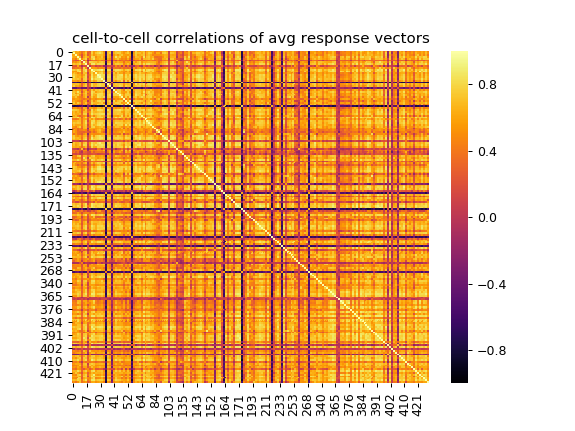

In [16]:
corr = configdf.corr(method='pearson')
pl.figure()
pl.title("cell-to-cell correlations of avg response vectors")
sns.heatmap(corr, cmap='inferno', vmin=-1, vmax=1)

<IPython.core.display.Javascript object>


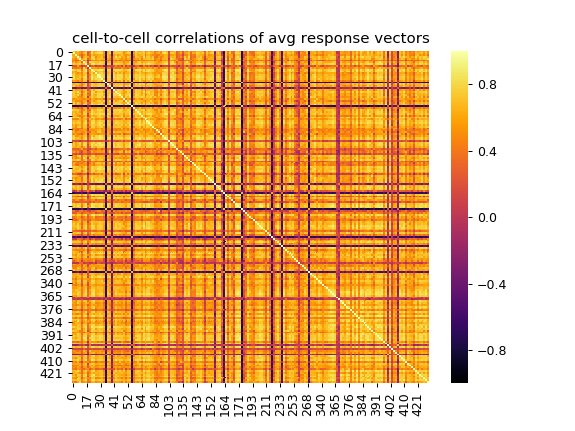

In [17]:
corr = configdf.corr(method='spearman')
pl.figure()
pl.title("cell-to-cell correlations of avg response vectors")
sns.heatmap(corr, cmap='inferno', vmin=-1, vmax=1)

In [68]:
corr.shape

(207, 207)

# Get position info

In [18]:
from scipy.spatial.distance import pdist, squareform


In [19]:
pos_fpath = glob.glob(os.path.join(aggregate_dir, 'roi_positions.pkl'))[0]
with open(pos_fpath, 'rb') as f:
    fovinfo = pkl.load(f)
    
fovinfo.keys()

['positions', 'ap_lim', 'ml_lim', 'dims']

In [20]:
posdf = fovinfo['positions']

In [21]:
posdf.head()

index      ap_pos      ml_pos visual_area animalid   session            fov
0      0  134.358419  961.493918          Li    JC076  20190422  FOV1_zoom2p0x
1      1   71.812258  938.601205          Li    JC076  20190422  FOV1_zoom2p0x
2      2   60.229636  930.970301          Li    JC076  20190422  FOV1_zoom2p0x
3      3  141.307992  938.601205          Li    JC076  20190422  FOV1_zoom2p0x
4      4  213.120250  944.324384          Li    JC076  20190422  FOV1_zoom2p0x

In [22]:
currpos = posdf.groupby(['animalid', 'session', 'fov']).get_group((animalid, session, fov))
currpos = currpos[currpos['index'].isin(roi_list)]
currpos.index = currpos['index']
_ =currpos.pop('index')
currpos = currpos[['ap_pos', 'ml_pos']]
pwdists = pdist(currpos[['ml_pos', 'ap_pos']], metric='euclidean')

### Double-check FOV position

<IPython.core.display.Javascript object>


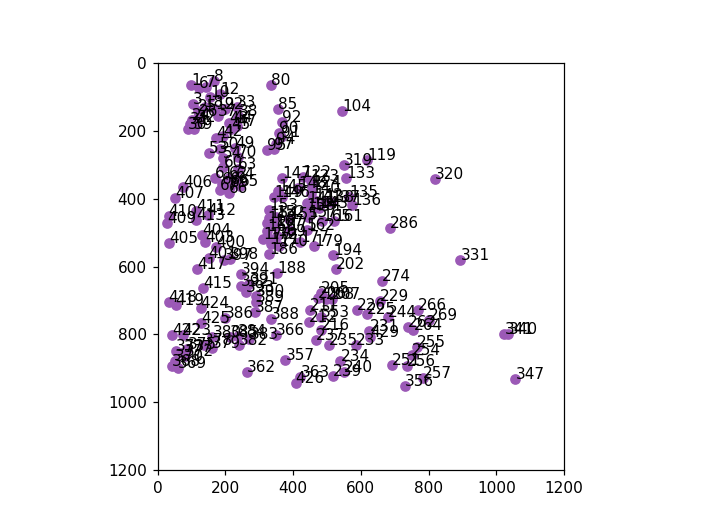

In [52]:
fig, ax = pl.subplots() #pl.figure()
ax.scatter(currpos['ap_pos'], currpos['ml_pos'])
for i in roi_list:
    xc = currpos['ap_pos'][i]
    yc = currpos['ml_pos'][i]
    ax.text(xc, yc, '%i' % int(i+1))
#ax.invert_yaxis()
ax.set_xlim([0, 1200])
ax.set_ylim([1200, 0])
ax.set_aspect('equal')

#### Look at pw distances

In [53]:
dist_matrix = squareform(pwdists)


In [54]:
len(pwdists)

16290

In [55]:
dist_matrix = pd.DataFrame(dist_matrix, index=roi_list, columns=roi_list)

<IPython.core.display.Javascript object>


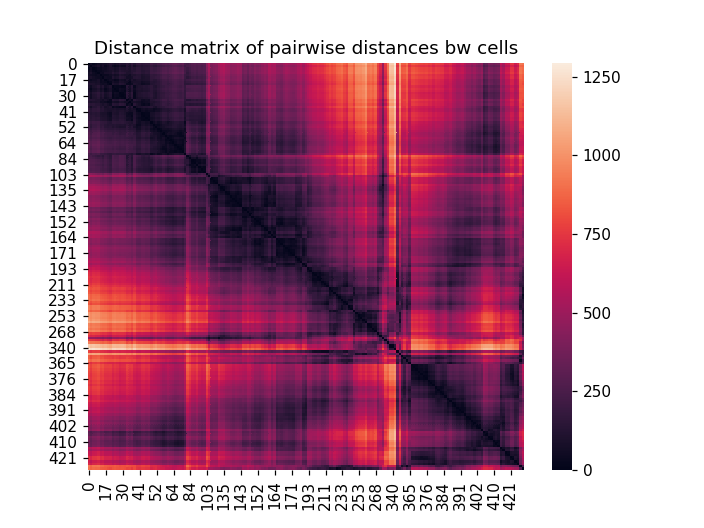

In [58]:
pl.figure()
pl.title("Distance matrix of pairwise distances bw cells")
sns.heatmap(dist_matrix)

In [28]:
corr = configdf.corr(method='pearson')

In [29]:
ucorr = corr.where(np.triu(np.ones(corr.shape), 1).astype(np.bool))
ucorr = ucorr.stack().reset_index()
ucorr.shape
ucorr.columns = ['row', 'col', 'value']

In [30]:
posdf.head()

index      ap_pos      ml_pos visual_area animalid   session            fov
0      0  134.358419  961.493918          Li    JC076  20190422  FOV1_zoom2p0x
1      1   71.812258  938.601205          Li    JC076  20190422  FOV1_zoom2p0x
2      2   60.229636  930.970301          Li    JC076  20190422  FOV1_zoom2p0x
3      3  141.307992  938.601205          Li    JC076  20190422  FOV1_zoom2p0x
4      4  213.120250  944.324384          Li    JC076  20190422  FOV1_zoom2p0x

In [31]:
roi = 0
currp = currpos.loc[roi]

currdists = (currpos[['ap_pos', 'ml_pos']] - np.array(currp)).pow(2).sum(1).pow(0.5)
len(currdists)

181

<IPython.core.display.Javascript object>


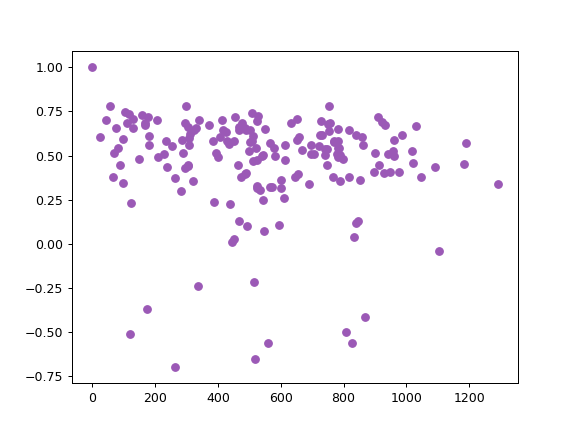

In [32]:
pl.figure()
pl.scatter(currdists, corr[0])

In [33]:
print len(roi_list)
print np.sqrt(len(roi_list))

181
13.45362404707371


In [34]:
corr = configdf.corr(method='pearson')


In [35]:
outdir = os.path.join(aggregate_dir, 'spatial-correlations', 'example-sessions')
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [36]:
16*12

192

<IPython.core.display.Javascript object>


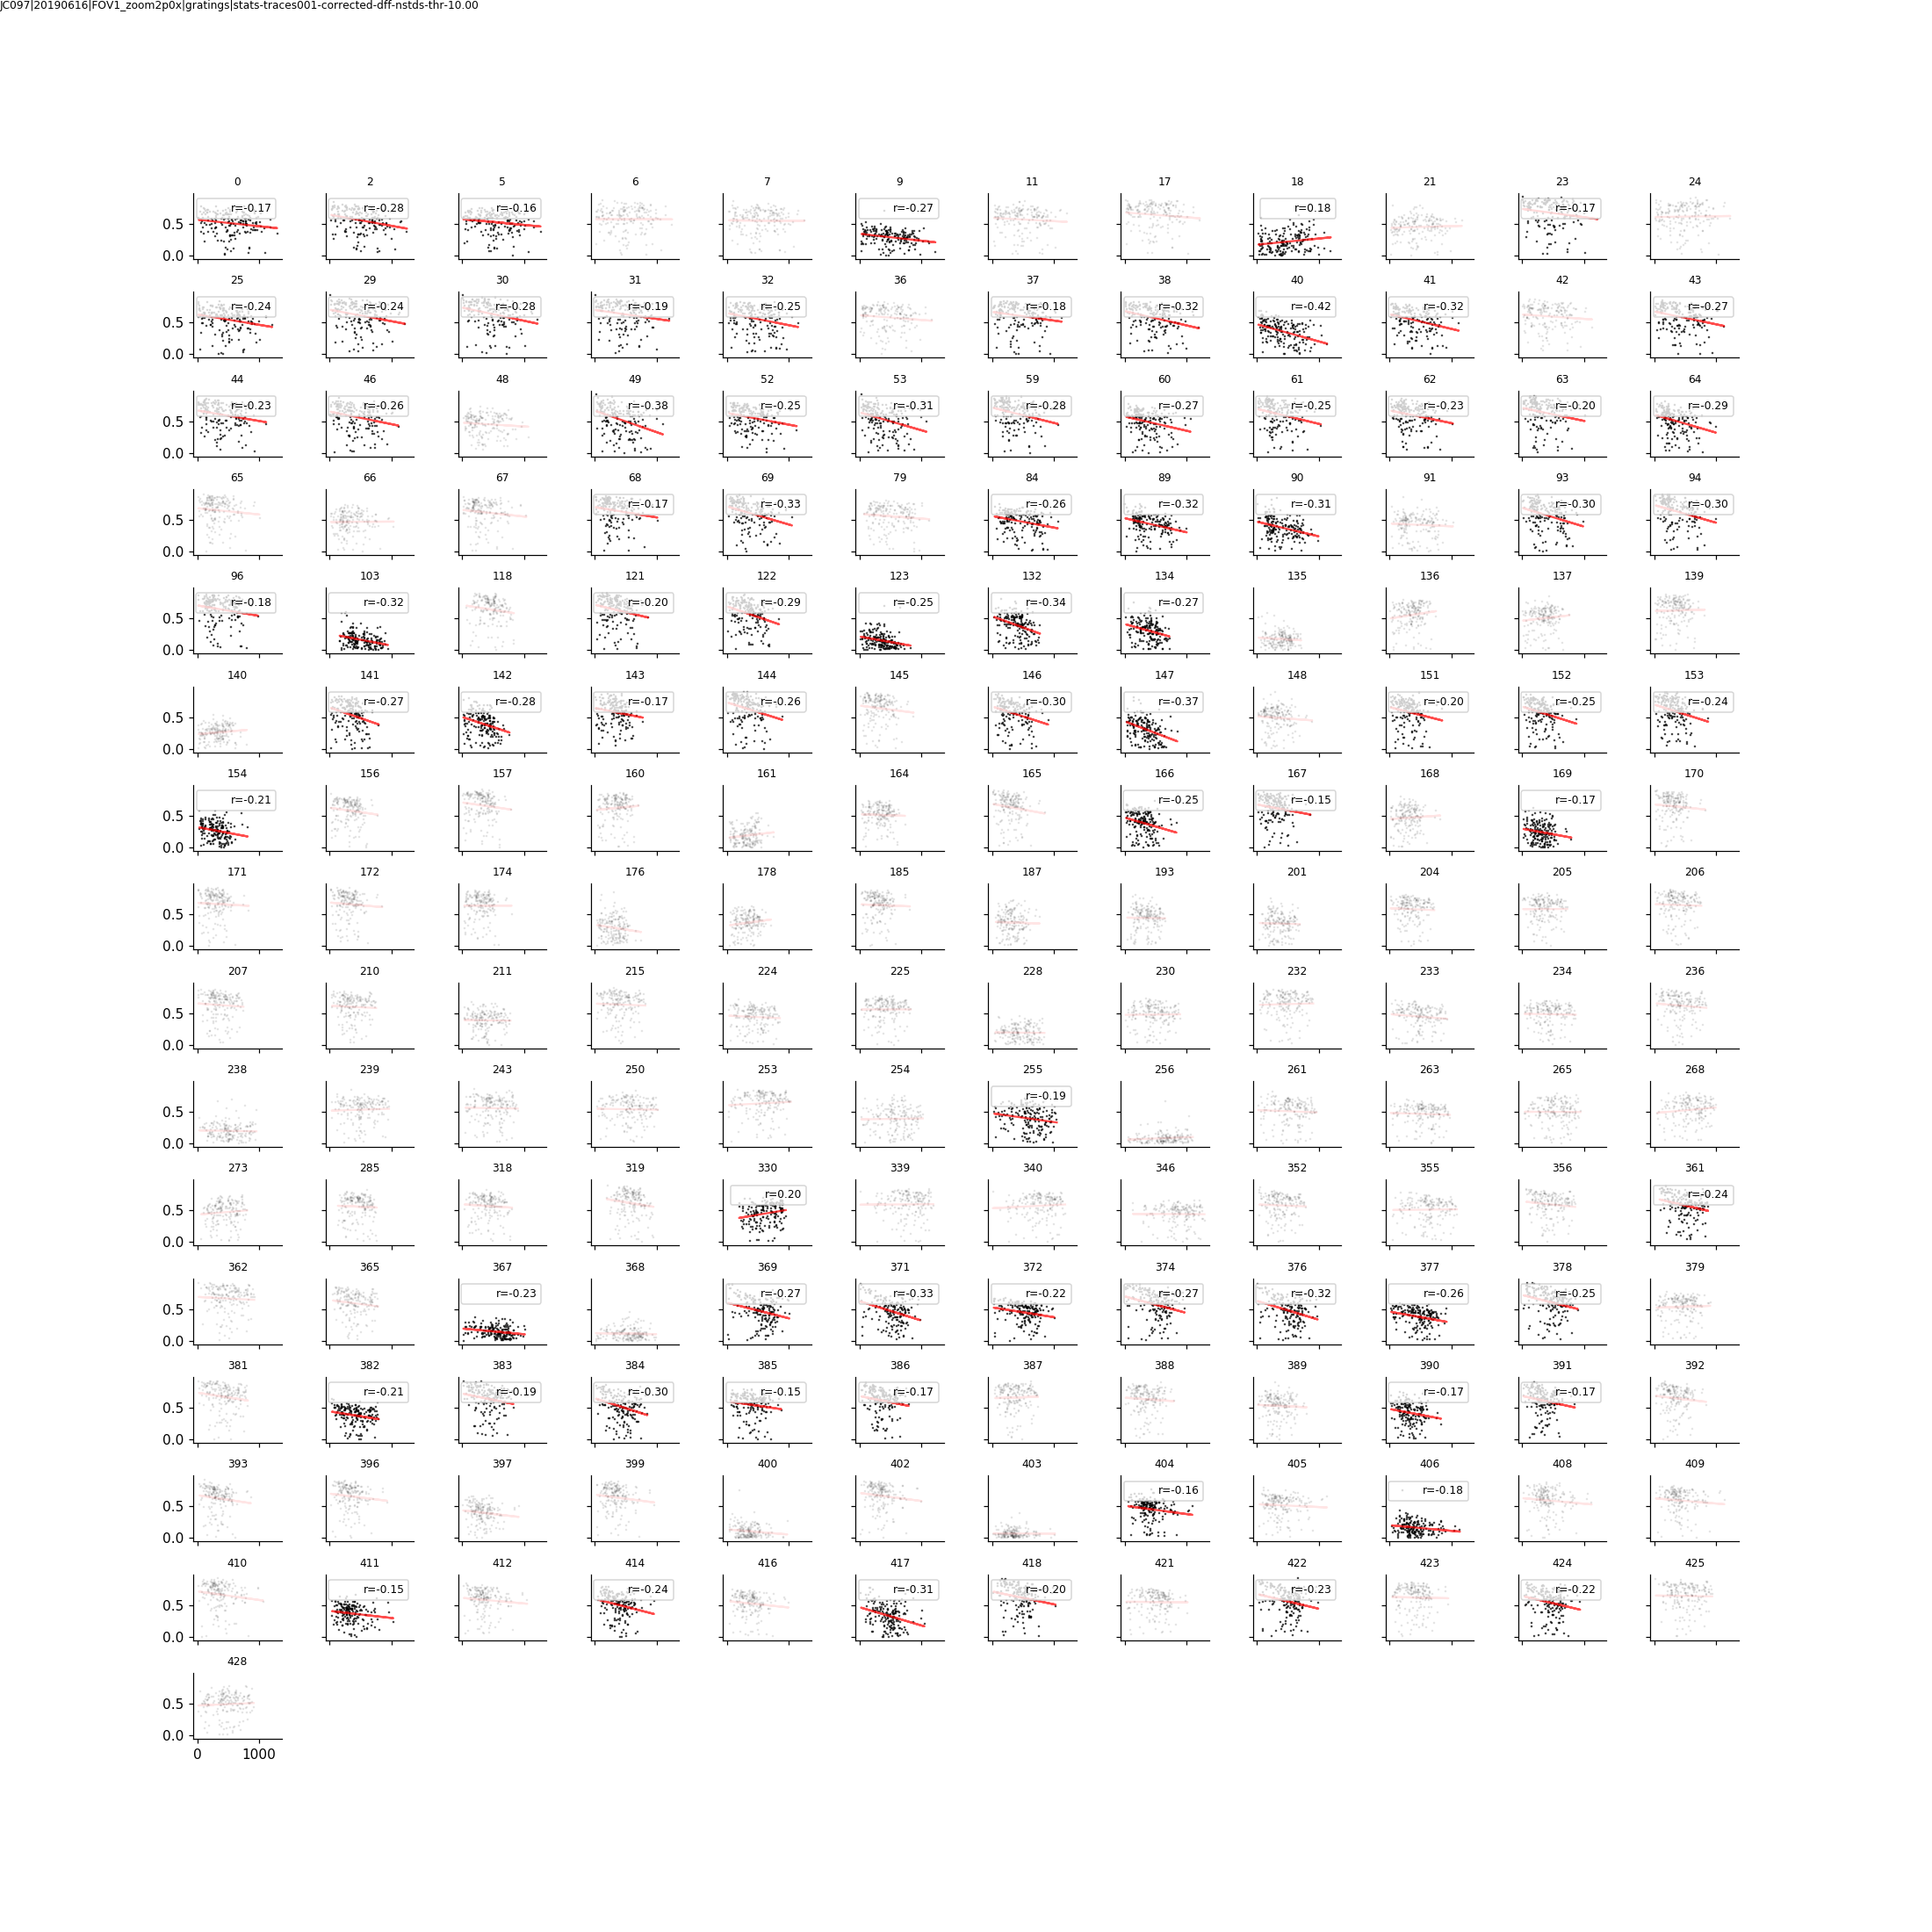

In [74]:
nplots = len(roi_list)

nr = 16
nc = 12

coeffs = []
fig, axes = pl.subplots(nr, nc, sharex=True, sharey=True, figsize=(20,20))
fig.patch.set_alpha(1)
ai = 0
for roi in roi_list: #[0:nplots]:
    ax = axes.flat[ai]
#     g = ucorr.groupby(['row']).get_group(roi)
#     ixs = g.index.tolist()
#     curr_dists = pwdists[ixs]
#     curr_corrs = g['value'].values
#     print len(curr_corrs)
    currp = currpos.loc[roi]

    curr_dists = (currpos[['ap_pos', 'ml_pos']] - np.array(currp)).pow(2).sum(1).pow(0.5).values
    ixs = np.array([i for i, r in enumerate(currpos.index.tolist()) if r != roi])
    curr_dists = curr_dists[ixs]
    
    curr_corrs = np.abs(corr[roi].values)
    ixs = np.array([i for i, r in enumerate(corr[roi].index.tolist()) if r!= roi])
    curr_corrs = curr_corrs[ixs]

    fitv, regr = fit_linear_regr(curr_dists, curr_corrs, return_regr=True)
    r, p = spstats.pearsonr(curr_dists, curr_corrs)
    label = 'r=%.2f' % r
    ax.plot(0, 0, alpha=0, label=label)
    if p < 0.05:
        ax.legend(loc='upper right', fontsize=8)
        alpha=0.7
        coeffs.append(r)
    else:
        alpha=0.1
    
    ax.scatter(curr_dists, curr_corrs, marker='+', s=1, c='k', alpha=alpha)
    ax.plot(curr_dists, fitv, 'r', alpha=alpha)
    ax.set_title(roi, fontsize=8)

    sns.despine(ax=ax)
    ai += 1

pl.subplots_adjust(wspace=0.5, hspace=0.5, left=0.1, right=0.9, top=0.9, bottom=0.1)
for ax in axes.flat[ai:]:
    ax.axis('off')
    
    
label_figure(fig, '|'.join([animalid, session, fov, 'gratings', stats_desc]))
pl.savefig(os.path.join(outdir, 'pw-distances_vs_cell-cell-corrs_example_stimconds__%s-%s.png' % (animalid, session)))


# Look at distn of corr coeffs

<IPython.core.display.Javascript object>


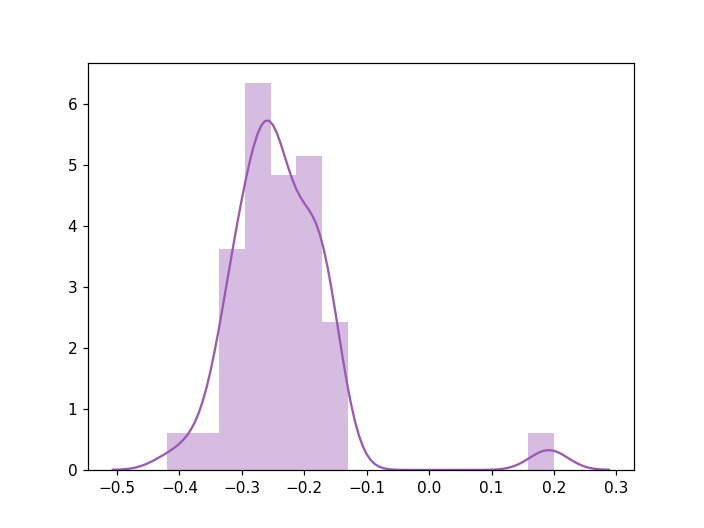

/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [75]:
fig, ax = pl.subplots()
sns.distplot(coeffs, ax=ax)

<IPython.core.display.Javascript object>


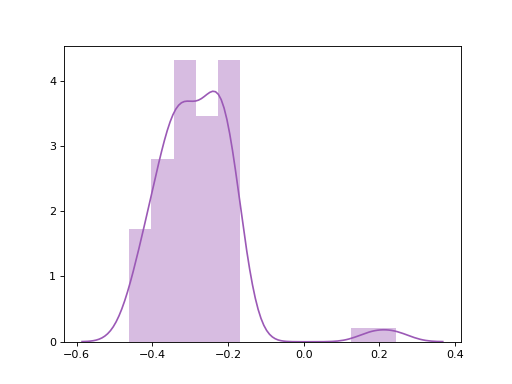

In [376]:
fig, ax = pl.subplots()
sns.distplot(coeffs, ax=ax)

In [38]:
from sklearn.linear_model import LinearRegression
import scipy.stats as spstats
import sklearn.metrics as skmetrics #import mean_squared_error

In [39]:
def fit_linear_regr(xvals, yvals, return_regr=False):
    regr = LinearRegression()
    if len(xvals.shape) == 1:
        xvals = np.array(xvals).reshape(-1, 1)
        yvals = np.array(yvals).reshape(-1, 1)
    else:
        xvals = np.array(xvals)
        yvals = np.array(yvals)
    regr.fit(xvals, yvals)
    fitv = regr.predict(xvals)
    if return_regr:
        return fitv.reshape(-1), regr
    else:
        return fitv.reshape(-1)

In [40]:
tstats.shape

(1280, 181)

In [41]:
experiment

'gratings'

<IPython.core.display.Javascript object>


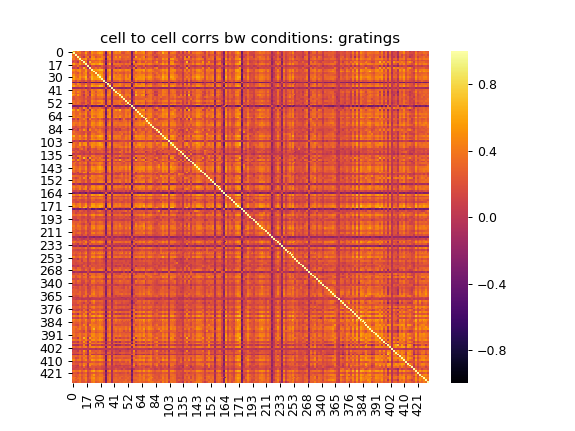

In [42]:
corr = tstats[roi_list].corr(method='pearson')
pl.figure()
pl.title("cell to cell corrs bw conditions: %s" % experiment)
sns.heatmap(corr, cmap='inferno', vmin=-1, vmax=1)

<IPython.core.display.Javascript object>


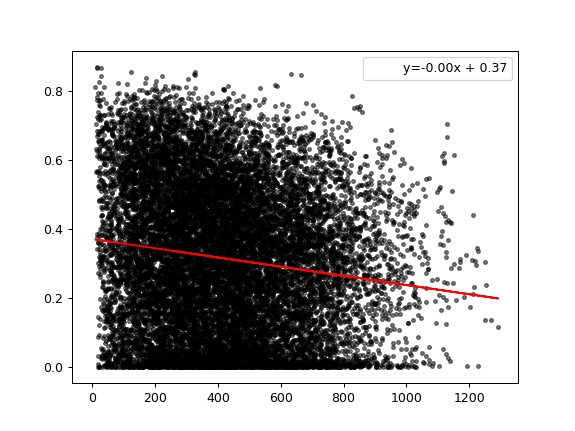

In [43]:

xv = pwdists
yv = ucorr['value']**2. #np.abs(ucorr['value'].values)

fitv, regr = fit_linear_regr(xv, yv, return_regr=True)

fig, ax = pl.subplots() #pl.figure()
ax.scatter(xv, yv, marker='.', alpha=0.5, c='k', label=None)
ax.plot(xv, fitv, 'r')
ax.plot(0,0, alpha=0, label='y=%.2fx + %.2f' % (float(regr.coef_), float(regr.intercept_)))

ax.legend(loc='upper right')

<IPython.core.display.Javascript object>


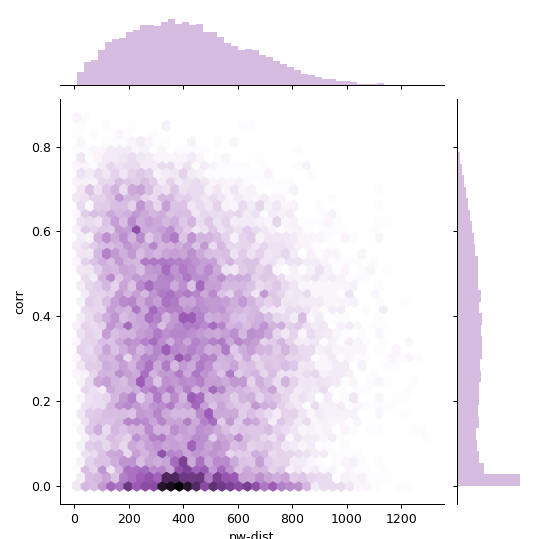

/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [44]:
g = sns.jointplot(xv, yv, kind='hex')
g.set_axis_labels('pw-dist', 'corr')

In [462]:
reload(util)

<module 'pipeline.python.classifications.experiment_classes' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py'>

# Aggregate all data

In [61]:
corr_method = 'pearson'

In [62]:
#corrcoef_fpath = os.path.join(aggregate_dir, 'cell-dist_v_cond-corrs_corrcoef-%s.pkl' % corr_method)
corrcoef_fpath = os.path.join(aggregate_dir, 'spatial-correlations','cell-dist_v_cond-corrs_corrcoef-%s_active-cells.pkl' % corr_method)


In [63]:

do_correlations = False
if os.path.exists(corrcoef_fpath):
    try:
        with open(corrcoef_fpath, 'rb') as f:
            df = pkl.load(f)
    except Exception as e:
        do_correlations = True
else:
    do_correlations = True

In [64]:
do_correlations

False

# Get all correlations between shared ROIs

In [50]:
df_list = []
for (visual_area, animalid, session, fov), g in sdata.groupby(['visual_area', 'animalid', 'session', 'fov']):
    S = util.Session(animalid, session, fov)
    roi_list = S.get_all_responsive_cells(traceid=traceid, response_type=response_type,
                                      responsive_test=responsive_test, responsive_thr=responsive_thr, fit_thr=0.5)

    
    currpos = posdf.groupby(['animalid', 'session', 'fov']).get_group((animalid, session, fov))
    currpos = currpos[currpos['index'].isin(roi_list)]
    currpos.index = currpos['index']
    _ =currpos.pop('index')
    currpos = currpos[['ap_pos', 'ml_pos']]

    for expname, exp in S.experiments.items():
        if 'retino' in expname:
            continue
        stats = exp.get_trial_metrics() #ex.get_trial_metrics()
        tstats = stats[roi_list]
    #     roi_list, nrois_total = ex.get_responsive_cells(responsive_test=responsive_test, 
    #                                                     responsive_thr=responsive_thr, 
    #                                                     n_stds=n_stds)
    #     tstats = tstats[roi_list]

        #pwdists = pdist(currpos[['ml_pos', 'ap_pos']], metric='euclidean')
        #corr = tstats.corr(method=corr_method)
        
        labels = exp.data.labels
        trial_refix = dict((trial, i) for i, trial in enumerate(sorted(labels['trial'].unique(), key=natural_keys)))
        cfgs = []
        for config, g in labels.groupby(['config']):
            trial_ixs = np.array([trial_refix[trial] for trial in sorted(g['trial'].unique(), key=natural_keys)])
            curr_trials = tstats.loc[trial_ixs]
            assert len(np.where(np.isnan(curr_trials))[0]) == 0
            cfgs.append( pd.Series(data=curr_trials.mean(axis=0), name=config) )
        configdf = pd.DataFrame(cfgs)
        corr = configdf.corr(method=corr_method)

        coeffs=[]; pvals=[];
        for roi in roi_list:

            # Get distance of each cell to current cell
            currp = currpos.loc[roi]
            curr_dists = (currpos[['ap_pos', 'ml_pos']] - np.array(currp)).pow(2).sum(1).pow(0.5).values
            ixs = np.array([i for i, r in enumerate(currpos.index.tolist()) if r != roi])
            curr_dists = curr_dists[ixs]

            # Get correlation between current cell's trial values and all other cells' trial values
            curr_corrs = np.abs(corr[roi].values)
            ixs = np.array([i for i, r in enumerate(corr[roi].index.tolist()) if r!= roi])
            curr_corrs = curr_corrs[ixs]

            #fitv, regr = fit_linear_regr(curr_dists, curr_corrs, return_regr=True)
            r, p = spstats.pearsonr(curr_dists, curr_corrs)

            coeffs.append(r)
            pvals.append(r)

        df_list.append( pd.DataFrame({'corrcoef': coeffs,
                                     'pval': pvals,
                                     'visual_area': [visual_area for _ in range(len(roi_list))],
                                     'animalid': [animalid for _ in range(len(roi_list))],
                                     'fov': [fov for _ in range(len(roi_list))],
                                      'session': [session for _ in range(len(roi_list))],
                                      'experiment': [expname for _ in range(len(roi_list))]},
                                    index=roi_list) )


df = pd.concat(df_list, axis=0).reset_index()
df['cell'] = df.pop('index')
print df.shape

with open(corrcoef_fpath, 'wb') as f:
    pkl.dump(df, f, protocol=pkl.HIGHEST_PROTOCOL)
    
    

[JC076] 20190422 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
traces001
... [JC076|20190422|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
... getting responsive cells (test: nstds, thr: 10.00')
--> [retino] not implemented
... loading data array
/n/coxfs01/2p-data/JC076/20190422/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_66b289_traces001_e95cc2_traces001_b96bf7_traces001_9cb69c_traces001_3485a6_traces001_7be2ae/data_arrays/np_subtracted.npz
adding NP offset...
[JC076] 20190502 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
traces001
... [JC076|20190502|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
... getting responsive cells (test: nstds, thr: 10.00')
... [JC076|20190502|FOV1_zoom2p0x] creating gratings object

Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 999, in load
    traceid=self.traceid)
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


TypeError: 'NoneType' object is not iterable

# Get correlations between active cells

In [65]:
#corr_method = 'pearson'
corrcoef_fpath = os.path.join(aggregate_dir, 'spatial-correlations', 'cell-dist_v_cond-corrs_corrcoef-%s_active-cells.pkl' % corr_method)


In [66]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/spatial-correlations/example-sessions'

In [67]:
if os.path.exists(corrcoef_fpath):
    with open(corrcoef_fpath, 'rb') as f:
        df = pkl.load(f)
df.keys()

Index([u'animalid', u'corrcoef', u'experiment', u'fov', u'pval', u'session',
       u'visual_area', u'cell'],
      dtype='object')

In [94]:
currdf = df[df['experiment'].isin(['rfs', 'rfs10'])]


In [95]:
for (visual_area, animalid, session, fov), g in currdf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    if len(g['experiment'].unique()) > 1:
        if 'rfs10' in g['experiment'].unique():
            #g[g['experiment']=='rfs'].index.tolist()
            drop_ix = g[g['experiment']=='rfs'].index.tolist()
            currdf = currdf.drop(drop_ix)

In [96]:
for (visual_area, animalid, session, fov), g in currdf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    print len(g['experiment'].unique())

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [97]:
data_identifier = '|'.join([fov_type, traceid, stats_desc])

data_identifier

'zoom2p0x|traces001|stats-traces001-corrected-dff-nstds-thr-10.00'

<IPython.core.display.Javascript object>


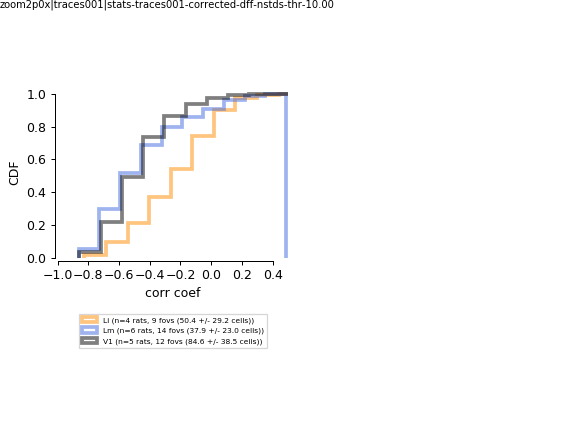

In [98]:
cdf = True
fig, ax = pl.subplots() #1,4, figsize=(12,4), sharex=True, sharey=True) #, 3, figsize=(12,4), sharex=True, sharey=True)
fig.patch.set_alpha(1)


for (visual_area), g in currdf.groupby(['visual_area']):
#     g = g[g['pval'] < 0.05]
#     if len(g) == 0:
#         continue
        
    values = g['corrcoef'].values
    weights = np.ones_like(values)/float(len(values))
    nrats = len(g['animalid'].unique())
    ncells_per_fov = g.groupby(['animalid', 'session', 'fov'])['cell'].count().values
    nfovs = len(ncells_per_fov)
    ncells_mean = np.mean(ncells_per_fov)
    ncells_std = np.std(ncells_per_fov)

    label = '%s (n=%i rats, %i fovs (%.1f +/- %.1f cells))' % (visual_area, nrats, nfovs, ncells_mean, ncells_std)
    ax.set_xlim([-1, 0.5])
    ax.hist(values, 
            cumulative=cdf,
            label=label,
            color=area_colors[visual_area],
            histtype='step', alpha=0.5, lw=3,
            normed=0, weights=weights)

    #ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)

    # Shrink current axis's height by 10% on the bottom
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
          fancybox=False, shadow=False, ncol=1, fontsize=6)



sns.despine(ax=ax, trim=True, offset=2)
ax.set_xlabel('corr coef')
if cdf:
    ax.set_ylabel('CDF')
else:
    ax.set_ylabel('fraction')

pl.subplots_adjust(right=0.5, left=0.1, wspace=.5, bottom=0.4, top=0.8)
label_figure(fig, data_identifier)

pl.savefig(os.path.join(aggregate_dir, 'spatial-correlations', 'RFS_corr_cell-dist_vs_config-resp_active-cells_NOFILT_no-repeats.png'))

<IPython.core.display.Javascript object>


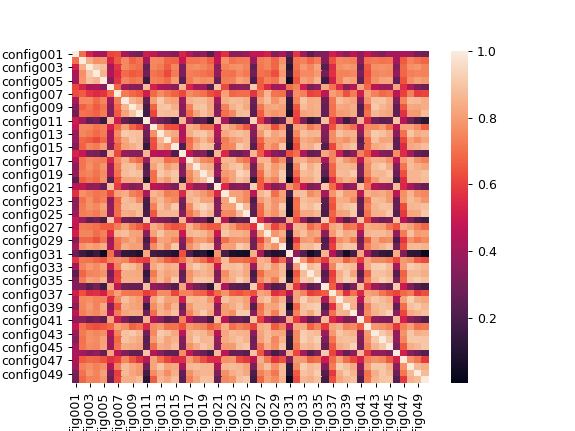

In [74]:
pl.figure()
sns.heatmap(configdf.T.corr())

In [55]:
configdfs = {}
df_list = []
for (visual_area, animalid, session, fov), g in sdata.groupby(['visual_area', 'animalid', 'session', 'fov']):
    if visual_area not in configdfs.keys():
        configdfs[visual_area] = {}
    S = util.Session(animalid, session, fov)
    all_cells = S.get_all_responsive_cells(traceid=traceid, response_type=response_type,
                                      responsive_test=responsive_test, responsive_thr=responsive_thr, fit_thr=0.5)
    for expname, exp in S.experiments.items():
        if 'retino' in expname:
            continue
        if expname not in configdfs[visual_area].keys():
            configdfs[visual_area][expname] = {}
            
        stats = exp.get_trial_metrics() #ex.get_trial_metrics()
        roi_list, nrois_total = exp.get_responsive_cells(responsive_test=responsive_test, 
                                                        responsive_thr=responsive_thr, 
                                                        n_stds=n_stds)
        tstats = stats[roi_list]

        #pwdists = pdist(currpos[['ml_pos', 'ap_pos']], metric='euclidean')
        #corr = tstats.corr(method=corr_method)

        currpos = posdf.groupby(['animalid', 'session', 'fov']).get_group((animalid, session, fov))
        currpos = currpos[currpos['index'].isin(roi_list)]
        currpos.index = currpos['index']
        _ =currpos.pop('index')
        currpos = currpos[['ap_pos', 'ml_pos']]

        labels = exp.data.labels
        trial_refix = dict((trial, i) for i, trial in enumerate(sorted(labels['trial'].unique(), key=natural_keys)))
        cfgs = []
        for config, g in labels.groupby(['config']):
            trial_ixs = np.array([trial_refix[trial] for trial in sorted(g['trial'].unique(), key=natural_keys)])
            curr_trials = tstats.loc[trial_ixs]
            assert len(np.where(np.isnan(curr_trials))[0]) == 0
            cfgs.append( pd.Series(data=curr_trials.mean(axis=0), name=config) )
        configdf = pd.DataFrame(cfgs)
        corr = configdf.corr(method=corr_method)
        
        configdfs[visual_area][expname].update({(animalid, session, fov): configdf})

        coeffs=[]; pvals=[];
        for roi in roi_list:

            # Get distance of each cell to current cell
            currp = currpos.loc[roi]
            curr_dists = (currpos[['ap_pos', 'ml_pos']] - np.array(currp)).pow(2).sum(1).pow(0.5).values
            ixs = np.array([i for i, r in enumerate(currpos.index.tolist()) if r != roi])
            curr_dists = curr_dists[ixs]

            # Get correlation between current cell's trial values and all other cells' trial values
            curr_corrs = np.abs(corr[roi].values)
            ixs = np.array([i for i, r in enumerate(corr[roi].index.tolist()) if r!= roi])
            curr_corrs = curr_corrs[ixs]

            #fitv, regr = fit_linear_regr(curr_dists, curr_corrs, return_regr=True)
            r, p = spstats.pearsonr(curr_dists, curr_corrs)

            coeffs.append(r)
            pvals.append(r)

        df_list.append( pd.DataFrame({'corrcoef': coeffs,
                                     'pval': pvals,
                                     'visual_area': [visual_area for _ in range(len(roi_list))],
                                     'animalid': [animalid for _ in range(len(roi_list))],
                                     'fov': [fov for _ in range(len(roi_list))],
                                      'session': [session for _ in range(len(roi_list))],
                                      'experiment': [expname for _ in range(len(roi_list))]},
                                    index=roi_list) )


df = pd.concat(df_list, axis=0).reset_index()
df['cell'] = df.pop('index')
print df.shape

with open(corrcoef_fpath, 'wb') as f:
    pkl.dump(df, f, protocol=pkl.HIGHEST_PROTOCOL)
    
    

[JC076] 20190422 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
traces001
... [JC076|20190422|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
... getting responsive cells (test: nstds, thr: 10.00')
--> [retino] not implemented
... loading data array
/n/coxfs01/2p-data/JC076/20190422/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_66b289_traces001_e95cc2_traces001_b96bf7_traces001_9cb69c_traces001_3485a6_traces001_7be2ae/data_arrays/np_subtracted.npz
adding NP offset...
... getting responsive cells (test: nstds, thr: 10.00')
[JC076] 20190502 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
traces001
... [JC076|20190502|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
... getting responsive cells (test: nstds, thr: 10.00')
...

Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 999, in load
    traceid=self.traceid)
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


TypeError: 'NoneType' object is not iterable

In [56]:
corrcoef_fpath

'/n/coxfs01/julianarhee/aggregate-visual-areas/spatial-correlations/cell-dist_v_cond-corrs_corrcoef-spearman_active-cells.pkl'

# Get average conditions for active cells (per area):

In [75]:
df_fpath = os.path.join(aggregate_dir, 'avg-conds-by-area-by-exp_active-cells.pkl')


In [15]:
configdfs = {}
for (visual_area, animalid, session, fov), g in sdata.groupby(['visual_area', 'animalid', 'session', 'fov']):
    if visual_area not in configdfs.keys():
        configdfs[visual_area] = {}
    S = util.Session(animalid, session, fov)
    all_cells = S.get_all_responsive_cells(traceid=traceid, response_type=response_type,
                                      responsive_test=responsive_test, responsive_thr=responsive_thr, fit_thr=0.5)
    for expname, exp in S.experiments.items():
        if 'retino' in expname:
            continue
        if expname not in configdfs[visual_area].keys():
            configdfs[visual_area][expname] = {}
            
        stats = exp.get_trial_metrics() #ex.get_trial_metrics()
        roi_list, nrois_total = exp.get_responsive_cells(responsive_test=responsive_test, 
                                                        responsive_thr=responsive_thr, 
                                                        n_stds=n_stds)
        tstats = stats[roi_list]

        labels = exp.data.labels
        trial_refix = dict((trial, i) for i, trial in enumerate(sorted(labels['trial'].unique(), key=natural_keys)))
        cfgs = []
        for config, g in labels.groupby(['config']):
            trial_ixs = np.array([trial_refix[trial] for trial in sorted(g['trial'].unique(), key=natural_keys)])
            curr_trials = tstats.loc[trial_ixs]
            assert len(np.where(np.isnan(curr_trials))[0]) == 0
            cfgs.append( pd.Series(data=curr_trials.mean(axis=0), name=config) )
        configdf = pd.DataFrame(cfgs)
        
        configdfs[visual_area][expname].update({(animalid, session, fov): configdf})


[JC076] 20190422 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
traces001
... [JC076|20190422|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
... getting responsive cells (test: nstds, thr: 10.00')
--> [retino] not implemented
... loading data array
/n/coxfs01/2p-data/JC076/20190422/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_66b289_traces001_e95cc2_traces001_b96bf7_traces001_9cb69c_traces001_3485a6_traces001_7be2ae/data_arrays/np_subtracted.npz
*****corrected offset unfound, running now*****
JC076 | 20190422 | FOV1_zoom2p0x | blobs | traces001
Found 60 raw file arrays.
**** File 1 of 60 *****
*** Excluding: []
/n/coxfs01/2p-data/JC076/20190422/FOV1_zoom2p0x/blobs_run1
N tsecs: 4600
There are 250 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 4150
... N unique frames: 4150
... Last frame to align: 45

KeyboardInterrupt: 

In [76]:
with open(df_fpath, 'wb') as f:
    pkl.dump(configdfs, f, protocol=pkl.HIGHEST_PROTOCOL)

In [215]:
exp = util.ReceptiveFields('rfs', animalid, session, fov, traceid=traceid)


... [JC097|20190617|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static


In [216]:
stats = exp.get_trial_metrics() #ex.get_trial_metrics()


... loading data array
... offset: 593.08
... adjusting for equal reps / condn...


# Get all trial data for active cells

In [223]:
visual_areas = ['V1', 'Lm', 'Li']
BLOBS=dict((v, dict()) for v in visual_areas)
RFS=dict((v, dict()) for v in visual_areas)
GRATS=dict((v, dict()) for v in visual_areas)

for visual_area in ['V1', 'Lm', 'Li']:
    dsets = sdata[sdata['visual_area']==visual_area]
    
    for (animalid, session, fov, experiment), g in dsets.groupby(['animalid', 'session', 'fov', 'experiment']):
        if 'rfs' in experiment:
            exp = util.ReceptiveFields(experiment, animalid, session, fov, traceid=traceid)
        elif 'gratings' in experiment:
            exp = util.Gratings(animalid, session, fov, traceid=traceid)
        elif 'blobs' in experiment:
            exp = util.Objects(animalid, session, fov, traceid=traceid)
        else:
            continue
            
        stats = exp.get_trial_metrics() #ex.get_trial_metrics()
        roi_list, nrois_total = exp.get_responsive_cells(responsive_test=responsive_test, 
                                                        responsive_thr=responsive_thr, 
                                                        n_stds=n_stds)
        stats = stats[roi_list]
        labels = exp.data.labels

        configs = []
        trials = []
        for (trial, config), g in labels.groupby(['trial', 'config']):
            configs.append(config)
            trials.append(trial)
        stats['trial'] = trials
        stats['config'] = configs
        
        skey = '-'.join([animalid, session, fov])
        
        if 'rfs' in experiment:
            RFS[visual_area].update({skey: stats})
        elif 'gratings' in experiment:
            GRATS[visual_area].update({skey: stats})
        elif 'blobs' in experiment:
            BLOBS[visual_area].update({skey: stats})

        

        

... [JC076|20190420|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
... loading data array
... offset: 253.29
... getting responsive cells (test: nstds, thr: 10.00')
... [JC076|20190420|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... loading data array
... offset: 251.51
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
... [JC076|20190501|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
... loading data array
... offset: 285.69
... getting responsive cells (test: nstds, thr: 10.00')
... [JC076|20190501|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... loading data array
.

... offset: 617.18
... adjusting for equal reps / condn...
... getting responsive cells (test: nstds, thr: 10.00')
... [JC097|20190617|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... loading data array
... offset: 608.50
... getting responsive cells (test: nstds, thr: 10.00')
... [JC097|20190617|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... loading data array
... offset: 593.08
... adjusting for equal reps / condn...
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
... [JC076|20190423|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... loading data array
... offset: 426.50
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-typ

... offset: 492.88
... adjusting for equal reps / condn...
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
... [JC084|20190525|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
... loading data array
... offset: 289.08
... getting responsive cells (test: nstds, thr: 10.00')
... [JC084|20190525|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... loading data array
... offset: 306.53
... getting responsive cells (test: nstds, thr: 10.00')
... [JC084|20190525|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... loading data array
... offset: 304.36
... adjusting for equal reps / condn...
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
.

... offset: 430.09
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
... [JC099|20190612|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
... loading data array
... offset: 572.09
... getting responsive cells (test: nstds, thr: 10.00')
... [JC099|20190612|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... loading data array
... offset: 603.70
... getting responsive cells (test: nstds, thr: 10.00')
... [JC099|20190612|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... loading data array
... offset: 552.08
... adjusting for equal reps / condn...
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
... [JC099|20190617

In [224]:
datastat_dir = os.path.join(aggregate_dir, 'data-stats', stats_desc)
if not os.path.exists(datastat_dir):
    os.makedirs(datastat_dir)
    
print datastat_dir

/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/stats-traces001-corrected-dff-nstds-thr-10.00


In [226]:
with open(os.path.join(datastat_dir, 'gratings.pkl'), 'wb') as f:
    pkl.dump(GRATS, f, protocol=pkl.HIGHEST_PROTOCOL)
    
with open(os.path.join(datastat_dir, 'blobs.pkl'), 'wb') as f:
    pkl.dump(BLOBS, f, protocol=pkl.HIGHEST_PROTOCOL)
    
with open(os.path.join(datastat_dir, 'rfs.pkl'), 'wb') as f:
    pkl.dump(RFS, f, protocol=pkl.HIGHEST_PROTOCOL)

# PLOT

In [77]:
visual_areas = ['V1', 'Lm', 'Li']
colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

In [78]:
for experiment, tmpd in df.groupby(['experiment']):
    if experiment == 'dynblobs':
        continue
    print experiment

blobs
gratings
rfs
rfs10


In [79]:
data_identifier = '|'.join([fov_type, traceid, stats_desc])
print data_identifier

zoom2p0x|traces001|stats-traces001-corrected-dff-nstds-thr-10.00


In [80]:
g.head()

animalid  corrcoef experiment            fov      pval   session  \
6367    JC076 -0.831726        rfs  FOV1_zoom2p0x -0.831726  20190420   
6368    JC076 -0.429726        rfs  FOV1_zoom2p0x -0.429726  20190420   
6369    JC076 -0.739552        rfs  FOV1_zoom2p0x -0.739552  20190420   
6370    JC076 -0.718410        rfs  FOV1_zoom2p0x -0.718410  20190420   
6371    JC076 -0.767342        rfs  FOV1_zoom2p0x -0.767342  20190420   

     visual_area  cell  
6367          V1     5  
6368          V1     7  
6369          V1    24  
6370          V1    25  
6371          V1    26

In [81]:
g.groupby(['animalid', 'session', 'fov'])['cell'].count().values

array([ 48,  17,  66,  38,  48, 111, 195, 181, 143, 124, 221,  85])

# Split by visual area

<IPython.core.display.Javascript object>


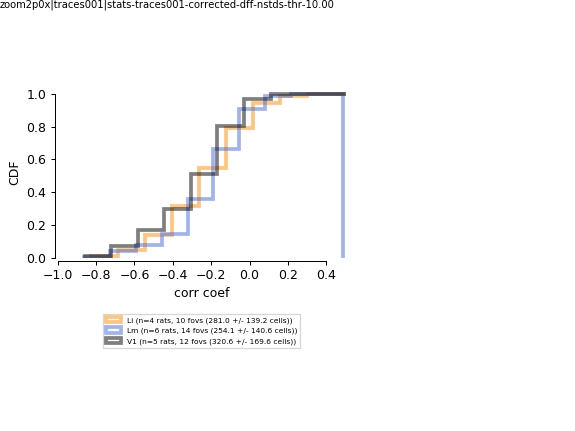

In [82]:
cdf = True
fig, ax = pl.subplots() #1,4, figsize=(12,4), sharex=True, sharey=True) #, 3, figsize=(12,4), sharex=True, sharey=True)
fig.patch.set_alpha(1)


for (visual_area), g in df.groupby(['visual_area']):
    #g = g[g['pval'] < 0.05]
    #if len(g) == 0:
    #    continue
        
    values = g['corrcoef'].values
    weights = np.ones_like(values)/float(len(values))
    nrats = len(g['animalid'].unique())
    ncells_per_fov = g.groupby(['animalid', 'session', 'fov'])['cell'].count().values
    nfovs = len(ncells_per_fov)
    ncells_mean = np.mean(ncells_per_fov)
    ncells_std = np.std(ncells_per_fov)

    label = '%s (n=%i rats, %i fovs (%.1f +/- %.1f cells))' % (visual_area, nrats, nfovs, ncells_mean, ncells_std)
    ax.set_xlim([-1, 0.5])
    ax.hist(values, 
            cumulative=cdf,
            label=label,
            color=area_colors[visual_area],
            histtype='step', alpha=0.5, lw=3,
            normed=0, weights=weights)

    #ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)

    # Shrink current axis's height by 10% on the bottom
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
          fancybox=False, shadow=False, ncol=1, fontsize=6)



sns.despine(ax=ax, trim=True, offset=2)
ax.set_xlabel('corr coef')
if cdf:
    ax.set_ylabel('CDF')
else:
    ax.set_ylabel('fraction')

pl.subplots_adjust(right=0.6, left=0.1, wspace=.5, bottom=0.4, top=0.8)
label_figure(fig, data_identifier)

pl.savefig(os.path.join(aggregate_dir, 'spatial-correlations', 'corr_cell-dist_vs_config-resp_active-cells.png'))

In [93]:
df.head()

animalid  corrcoef experiment            fov      pval   session  \
0    JC076  0.144737      blobs  FOV1_zoom2p0x  0.144737  20190422   
1    JC076 -0.271459      blobs  FOV1_zoom2p0x -0.271459  20190422   
2    JC076 -0.358911      blobs  FOV1_zoom2p0x -0.358911  20190422   
3    JC076 -0.277390      blobs  FOV1_zoom2p0x -0.277390  20190422   
4    JC076 -0.289651      blobs  FOV1_zoom2p0x -0.289651  20190422   

  visual_area  cell  
0          Li     0  
1          Li     1  
2          Li     2  
3          Li     3  
4          Li     4

In [100]:
import copy

# Select datasets - no reps

IGNORE THESE:
V1:  JC076-20190501, JC083-20190510
    - if blobs & rfs only: ignore JC083_20190511, else ALSO ignore: 20190507-JC083
Lm:  JC078-20190509, JC080-20190506, JC083-20190517
    - if blobs & rfs only: ignore JC078-2019513, else ALSO ignore: JC078-20190430
    - if blobs & rfs only: ignore JC083-20190512, else ALSO ignore: JC083-20190508
Li:  JC076-20190422, JC099-20190509, JC091-20190607, JC091-20190606
    

In [101]:
always_exclude = ['JC076-20190501', 'JC083-20190510', 
                  'JC078-20190426', 'JC078-20190509', 'JC080-20190506', 'JC083-20190517',
                 'JC076-20190422', 'JC099-20190509', 'JC091-20190607', 'JC091-20190606']
# also_exclude = ['JC083-20190511', 
#                 'JC078-2019513', 'JC083-20190512']
also_exclude = ['JC083-20190507', 
                'JC078-2019430', 'JC083-20190508']


excluded_sessions = copy.copy(always_exclude)
excluded_sessions.extend(also_exclude)
print(len(excluded_sessions))

13


In [103]:
fdf = df.copy()
for (animalid, session, fov), g in fdf.groupby(['animalid', 'session', 'fov']):
    if '-'.join([animalid, session]) in excluded_sessions:
        drop_ix = g.index.tolist()
        fdf = fdf.drop(drop_ix)

In [106]:
fdf[fdf['animalid']=='JC078']['session'].unique()

array(['20190430', '20190504', '20190513'], dtype=object)

# Split by experiment type

<IPython.core.display.Javascript object>


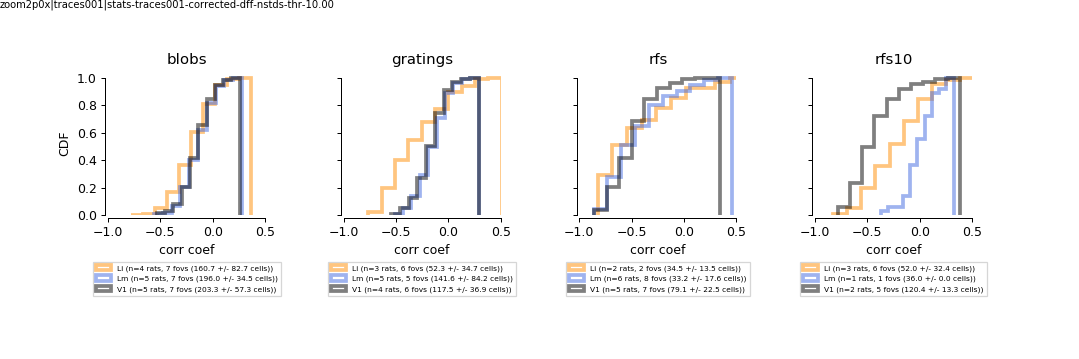

In [107]:
cdf = True
fig, axes = pl.subplots(1,4, figsize=(12,4), sharex=True, sharey=True) #, 3, figsize=(12,4), sharex=True, sharey=True)
fig.patch.set_alpha(1)

ai = 0
for experiment, tmpd in fdf.groupby(['experiment']):
    if experiment == 'dynblobs':
        continue
    
    ax = axes[ai]
    for (visual_area), g in tmpd.groupby(['visual_area']):
#         g = g[g['pval'] < 0.05]
#         if len(g) == 0:
#             continue
        values = g['corrcoef'].values
        weights = np.ones_like(values)/float(len(values))
        nrats = len(g['animalid'].unique())
        ncells_per_fov = g.groupby(['animalid', 'session', 'fov'])['cell'].count().values
        nfovs = len(ncells_per_fov)
        ncells_mean = np.mean(ncells_per_fov)
        ncells_std = np.std(ncells_per_fov)
        
        label = '%s (n=%i rats, %i fovs (%.1f +/- %.1f cells))' % (visual_area, nrats, nfovs, ncells_mean, ncells_std)
        ax.set_xlim([-1, 0.5])
        ax.hist(values, 
                cumulative=cdf,
                label=label,
                color=area_colors[visual_area],
                histtype='step', alpha=0.5, lw=3,
                normed=0, weights=weights)

        #ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)

        # Shrink current axis's height by 10% on the bottom
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + box.height * 0.1,
                         box.width, box.height * 0.9])

        # Put a legend below current axis
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
                  fancybox=False, shadow=False, ncol=1, fontsize=6)

    ax.set_title(experiment)
    ai += 1
    
for ai, ax in enumerate(axes):
    sns.despine(ax=ax, trim=True, offset=2)
    ax.set_xlabel('corr coef')
    if ai == 0:
        if cdf:
            ax.set_ylabel('CDF')
        else:
            ax.set_ylabel('fraction')

pl.subplots_adjust(right=0.9, left=0.1, wspace=.5, bottom=0.4, top=0.8)
label_figure(fig, data_identifier)

pl.savefig(os.path.join(aggregate_dir, 'pearsons-corr_cell-corr-across-stimcond_vs_cell-distance_by-experiment_NOFILT_norepeats.png'))

<IPython.core.display.Javascript object>


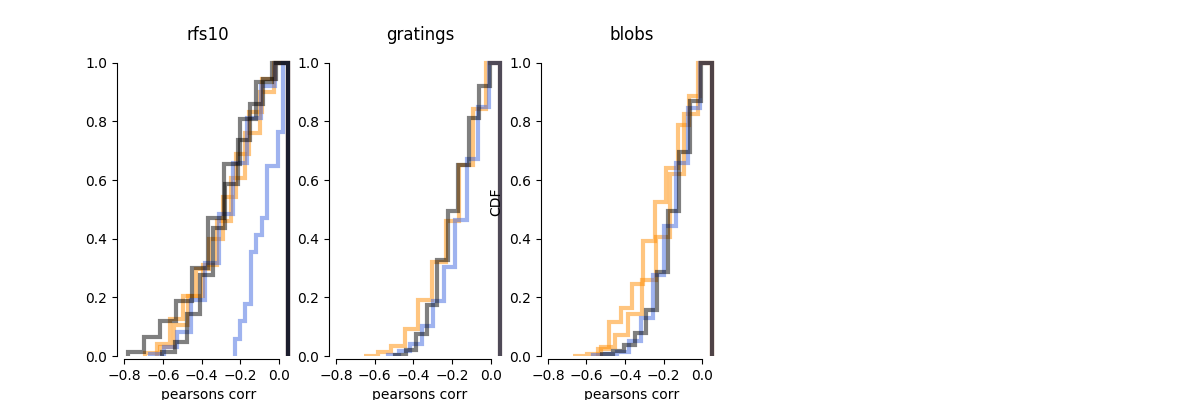

In [128]:
cdf = True
fig, axes = pl.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True)

for (visual_area, experiment), tmpd in df.groupby(['visual_area', 'experiment']):
    g = tmpd[tmpd['pval'] < 0.05]

    if 'rfs' in experiment:
        if 'rfs' in tmpd.groupby(['experiment']).groups.keys() and 'rfs10' in tmpd.groupby(['experiment']).groups.keys():
            if experiment == 'rfs':
                continue
            else:
                ax = axes[0]
        else:
            ax = axes[0]
    elif experiment == 'gratings':
        ax = axes[1]
    elif experiment == 'blobs':
        ax = axes[2]

    values = g['corrcoef'].values
    weights = np.ones_like(values)/float(len(values))

    nfovs = len(g.groupby(['animalid', 'session', 'fov']).groups)
    if i==0:
        label = '%s (n=%i rats, %i fovs)' % (visual_area, nrats, nfovs)
    else:
        label = None
    ax.hist(values, 
            cumulative=cdf,
            label=label,
            color=area_colors[visual_area],
            histtype='step', alpha=0.5, lw=3,
            normed=0, weights=weights)

    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
    ax.set_title(experiment)

        
for ax in axes:
    sns.despine(ax=ax, trim=True, offset=2)
    ax.set_xlabel('pearsons corr')
if cdf:
    ax.set_ylabel('CDF')
else:
    ax.set_ylabel('fraction')
    
pl.subplots_adjust(right=0.6, left=0.1, wspace=0.2)



<IPython.core.display.Javascript object>


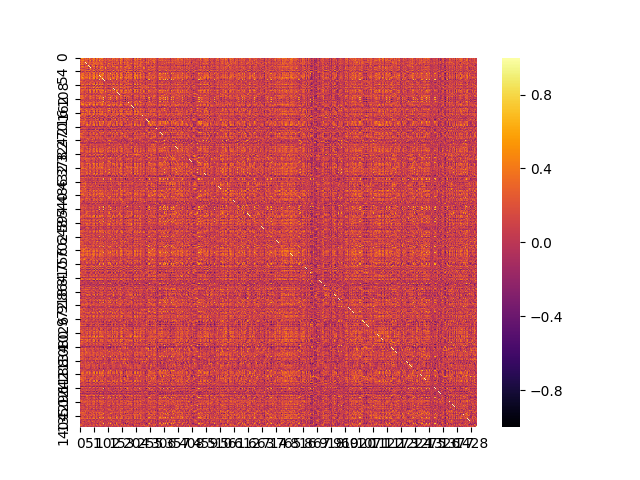

In [122]:
corr_trials = tstats.T.corr()
pl.figure()
sns.heatmap(corr_trials, cmap='inferno', vmin=-1, vmax=1)

<IPython.core.display.Javascript object>


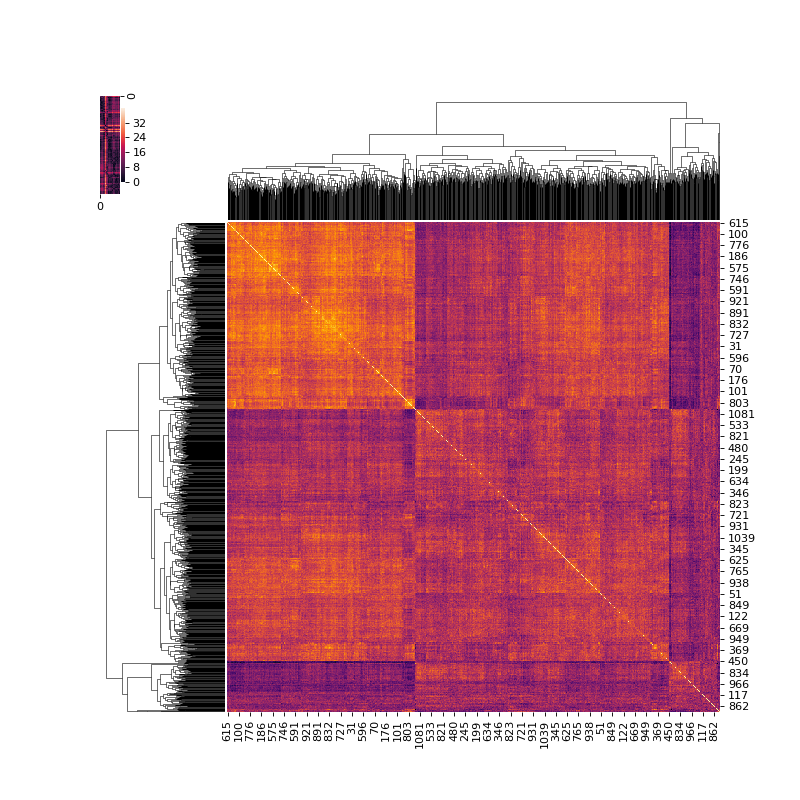

In [45]:
sns.clustermap(corr_trials, cmap='inferno', z_score=None)